In [3]:
#環境設置與套件安裝
# 匯入所需套件
import yfinance as yf
import pandas as pd
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout
import warnings
import random
import numpy as np
import tensorflow as tf
import os
warnings.filterwarnings('ignore')

# 設定隨機種子，確保結果可重現
RANDOM_SEED = 42

#Anaconda抓字型
!curl -L -o TaipeiSansTCBeta-Regular.ttf "https://drive.google.com/uc?id=1eGAsTN1HBpJAkeVM57_C7ccp7hbgSz3_&export=download"

import matplotlib

# 改style要在改font之前
# plt.style.use('seaborn')
from matplotlib import font_manager as fm
fm.fontManager.addfont('TaipeiSansTCBeta-Regular.ttf')
matplotlib.rc('font', family='Taipei Sans TC Beta')
matplotlib.rcParams['axes.unicode_minus'] = False

print(" 環境設置完成！")

 環境設置完成！


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0

  0     0    0     0    0     0      0      0 --:--:--  0:00:01 --:--:--     0
  0     0    0     0    0     0      0      0 --:--:--  0:00:02 --:--:--     0
100 19.7M  100 19.7M    0     0  6663k      0  0:00:03  0:00:03 --:--:-- 12.7M


In [4]:
def set_random_seeds(seed=RANDOM_SEED):
    """
    設定所有相關套件的隨機種子，確保實驗可重現

    為什麼需要設定多個種子？
    - Python random: 影響資料打亂、隨機抽樣
    - NumPy: 影響權重初始化、資料分割
    - TensorFlow: 影響網路權重初始化、dropout等
    - OS環境變數: 確保GPU運算也是確定性的
    """
    print(f"🎯 設定隨機種子為 {seed}，確保實驗可重現...")

    # 1. Python 內建 random
    random.seed(seed)
    print(f"   ✓ Python random.seed({seed})")

    # 2. NumPy 隨機種子
    np.random.seed(seed)
    print(f"   ✓ NumPy np.random.seed({seed})")

    # 3. TensorFlow 隨機種子
    tf.random.set_seed(seed)
    print(f"   ✓ TensorFlow tf.random.set_seed({seed})")

    # 4. 設定環境變數確保GPU運算確定性
    os.environ['PYTHONHASHSEED'] = str(seed)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'
    print(f"   ✓ 環境變數 PYTHONHASHSEED & TF_DETERMINISTIC_OPS")

    # 5. 設定 TensorFlow GPU 確定性運算
    try:
        # TensorFlow 2.8+ 的方法
        tf.config.experimental.enable_op_determinism()
        print(f"   ✓ TensorFlow GPU 確定性運算已啟用")
    except AttributeError:
        # 較舊版本的 TensorFlow
        print(f"   ⚠️ TensorFlow 版本較舊，部分確定性設定可能無效")

    print("✅ 隨機種子設定完成！每次執行結果將完全一致")

# 執行種子設定
set_random_seeds(RANDOM_SEED)

🎯 設定隨機種子為 42，確保實驗可重現...
   ✓ Python random.seed(42)
   ✓ NumPy np.random.seed(42)
   ✓ TensorFlow tf.random.set_seed(42)
   ✓ 環境變數 PYTHONHASHSEED & TF_DETERMINISTIC_OPS
   ✓ TensorFlow GPU 確定性運算已啟用
✅ 隨機種子設定完成！每次執行結果將完全一致


In [8]:
def get_stock_data(stock_id='ORCL', start_date='2020-01-01', end_date='2025-09-30'):
    print(f" 正在獲取 {stock_id} 的歷史資料...")

    start = dt.datetime.strptime(start_date, '%Y-%m-%d')
    end = dt.datetime.strptime(end_date, '%Y-%m-%d')

    stock_data = yf.download(stock_id, start=start, end=end)
    stock_data = stock_data.reset_index()
    stock_data["Date"] = pd.to_datetime(stock_data["Date"])
    stock_data.set_index("Date", inplace=True)

    print(f" 成功獲取 {len(stock_data)} 筆資料")
    print(f" 資料區間: {stock_data.index[0].date()} 到 {stock_data.index[-1].date()}")

    return stock_data

# 執行資料獲取
stock_data = get_stock_data('ORCL') # stock_id='2330.TW', start_date='2020-01-01', end_date='2024-10-10'

# 資料探索分析
print(f"\n 甲骨文股價資料概覽:")
print(f"資料形狀: {stock_data.shape}")
print(f"欄位名稱: {list(stock_data.columns)}")
print(f"\n前5筆資料:")
print(stock_data.head())

 正在獲取 ORCL 的歷史資料...


[*********************100%***********************]  1 of 1 completed

 成功獲取 1443 筆資料
 資料區間: 2020-01-02 到 2025-09-29

 甲骨文股價資料概覽:
資料形狀: (1443, 5)
欄位名稱: [('Close', 'ORCL'), ('High', 'ORCL'), ('Low', 'ORCL'), ('Open', 'ORCL'), ('Volume', 'ORCL')]

前5筆資料:
Price           Close       High        Low       Open    Volume
Ticker           ORCL       ORCL       ORCL       ORCL      ORCL
Date                                                            
2020-01-02  49.537422  49.546603  48.876310  48.913039  13899600
2020-01-03  49.362972  49.629254  48.619224  48.655954  11026700
2020-01-06  49.620068  49.766981  48.986500  48.995685  10982400
2020-01-07  49.730251  49.886349  49.225237  49.482334  12015400
2020-01-08  49.923935  50.357412  49.527347  49.748696  11856700


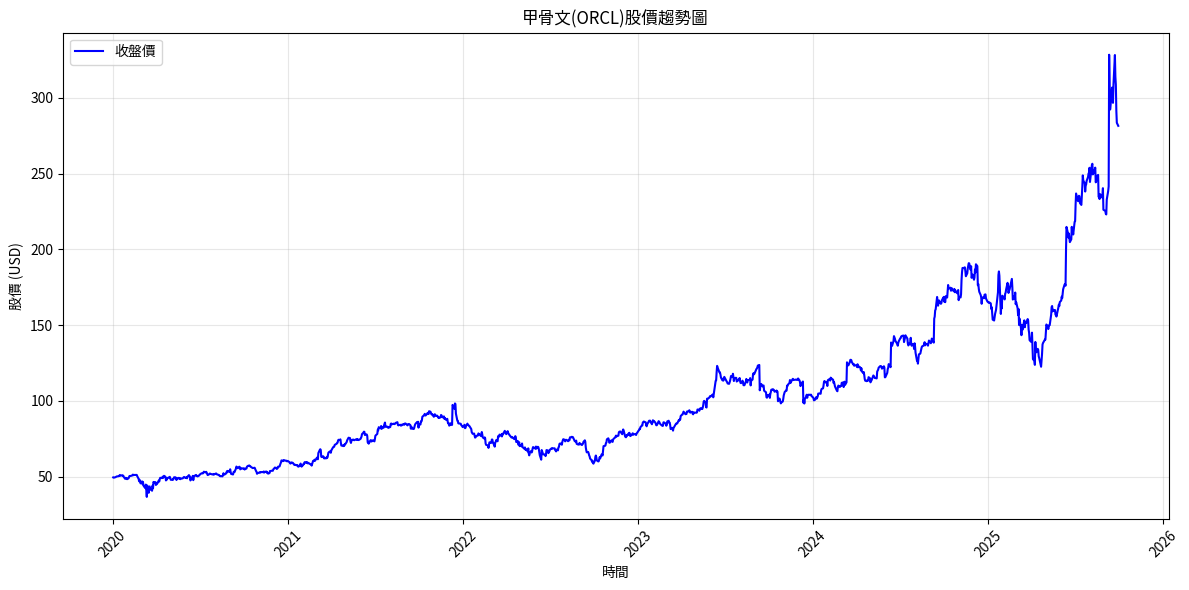

In [10]:
# 視覺化股價趨勢
plt.figure(figsize=(12, 6))
plt.plot(stock_data.index, stock_data['Close'], label='收盤價', color='blue')
plt.title('甲骨文(ORCL)股價趨勢圖')
plt.xlabel('時間')
plt.ylabel('股價 (USD)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [11]:
def prepare_close_only_features(data):
    """
    方案一：僅使用收盤價特徵

    設計理念：
    - 最簡單的特徵設計
    - 避免特徵間共線性問題
    - 測試模型對單一時序的學習能力
    """
    print("📉 準備 Close Only 特徵...")

    df = data[['Close']].copy()
    df = df.dropna()

    # 處理多層索引
    if isinstance(df.columns[0], tuple):
        df.columns = [col[0] for col in df.columns]

    print(f" Close Only 特徵準備完成，形狀: {df.shape}")
    return df, ['Close']

def prepare_ohlcv_features(data):
    """
    方案二：使用完整 OHLCV 特徵

    設計理念：
    - Open: 市場開盤情緒
    - High/Low: 當日波動範圍
    - Close: 收盤共識價格
    - Volume: 交易量（市場活躍度）
    """
    print(" 準備 OHLCV 完整特徵...")

    #feature_columns = ['Open', 'High', 'Low', 'Close', 'Volume']
    feature_columns = ['Open', 'High', 'Low']
    df = data[feature_columns].copy()
    df = df.dropna()

    if isinstance(df.columns[0], tuple):
        df.columns = [col[0] for col in df.columns]

    print(f" OHLCV 特徵準備完成，形狀: {df.shape}")
    print(f"特徵維度: {feature_columns}")
    return df, feature_columns

In [12]:
def create_dataset_single_step(dataset, window_size, target_col_idx=0):

    X, y = [], []

    print(f" 建立時序資料集，視窗大小: {window_size} 天")

    for i in range(len(dataset) - window_size):
        # 輸入：過去window_size天的所有特徵
        X.append(dataset[i:i + window_size, :])
        # 目標：下一天的收盤價
        y.append(dataset[i + window_size, target_col_idx])

    X = np.array(X)
    y = np.array(y)

    print(f" 時序資料集建構完成")
    print(f"   輸入形狀 X: {X.shape} (樣本數, 時間步長, 特徵數)")
    print(f"   目標形狀 y: {y.shape}")

    return X, y

def prepare_data(features_data, window_size, target_col_name='Close'):

    print(f"\n 準備 {target_col_name} 預測資料...")

    # 1. 找到目標欄位索引
    feature_columns = features_data.columns.tolist()

    def extract_column_name(col):
        if isinstance(col, tuple):
            return col[0]
        return str(col)

    column_names = [extract_column_name(col) for col in feature_columns]

    # 智能尋找收盤價欄位
    if target_col_name in column_names:
        target_col_idx = column_names.index(target_col_name)
    elif 'Close' in column_names:
        target_col_idx = column_names.index('Close')
        target_col_name = 'Close'
    else:
        target_col_idx = len(feature_columns) - 1
        target_col_name = column_names[target_col_idx]

    print(f" 目標欄位: {target_col_name} (索引: {target_col_idx})")

    # 2. 時序分割：保持時間順序
    train_size = int(len(features_data) * 0.8)
    train_data = features_data[:train_size]
    test_data = features_data[train_size:]

    print(f" 時序分割: 訓練 {len(train_data)} 筆，測試 {len(test_data)} 筆")

    # 3. 特徵標準化

    scaler = MinMaxScaler(feature_range=(0, 1))


    train_scaled = scaler.fit_transform(train_data) # 訓練集：學習參數 + 應用轉換
    test_scaled = scaler.transform(test_data) # 測試集：只應用轉換，不重新學習參數


    print(" MinMax 正規化完成 (0-1 縮放)")

    # 4. 時序資料集建構
    X_train, y_train = create_dataset_single_step(train_scaled, window_size, target_col_idx)
    X_test, y_test = create_dataset_single_step(test_scaled, window_size, target_col_idx)

    return X_train, y_train, X_test, y_test, scaler, train_data, test_data, target_col_idx

def inverse_transform_predictions(scaler, y_true, y_pred, n_features, target_col_idx):

    def inverse_transform_target(scaler, y_scaled, n_features, target_col_idx):
        if len(y_scaled.shape) == 1:
            y_scaled = y_scaled.reshape(-1, 1)

        dummy = np.zeros((len(y_scaled), n_features))
        dummy[:, target_col_idx] = y_scaled.flatten()
        dummy_inv = scaler.inverse_transform(dummy)
        return dummy_inv[:, target_col_idx]

    y_true_actual = inverse_transform_target(scaler, y_true, n_features, target_col_idx)
    y_pred_actual = inverse_transform_target(scaler, y_pred, n_features, target_col_idx)

    return y_true_actual, y_pred_actual

In [13]:
# 設定超參數
WINDOW_SIZE = 30  # 時間視窗：30天
EPOCHS = 100       # 訓練輪數
BATCH_SIZE = 128   # 批次大小

print(f" 全域參數設定:")
print(f"   時間視窗: {WINDOW_SIZE} 天")
print(f"   訓練輪數: {EPOCHS}")
print(f"   批次大小: {BATCH_SIZE}")

 全域參數設定:
   時間視窗: 30 天
   訓練輪數: 100
   批次大小: 128


In [14]:
#深度學習模型架構
def build_lstm_model(input_shape, output_dim=1, lstm_units=64, dense_units=[64, 32]):

    print(f" 建立 LSTM 時序預測模型...")
    print(f"   輸入形狀: {input_shape}")
    print(f"   LSTM 單元數: {lstm_units}")
    print(f"   全連接層結構: {dense_units}")

    model = Sequential(name='LSTM_Stock_Predictor')

    # 時序輸入層
    model.add(Input(shape=input_shape))

    # LSTM 層：時序特徵提取
    model.add(LSTM(lstm_units, name='LSTM_Layer',
                   return_sequences=False))  # 只返回最後時間步

    # 全連接層：非線性特徵轉換
    for i, units in enumerate(dense_units):
        model.add(Dense(units, activation='relu', name=f'Dense_{i+1}'))
        model.add(Dropout(0.2, name=f'Dropout_{i+1}'))

    # 輸出層：回歸預測
    model.add(Dense(output_dim, activation='linear', name='Output'))

    # 編譯模型
    model.compile(
        optimizer='adam',
        loss='mse',  # 回歸任務使用 MSE
        metrics=['mae']
    )

    print(" LSTM 模型建構完成")
    return model

def build_dnn_model(input_shape, output_dim=1, hidden_units=[128, 64, 32]):

    print(f"🤖 建立 DNN 深度預測模型...")

    # 計算攤平後維度
    if len(input_shape) == 1:
        input_dim = input_shape[0]
    else:
        input_dim = input_shape[0] * input_shape[1]

    print(f"   攤平輸入維度: {input_dim}")
    print(f"   隱藏層結構: {hidden_units}")

    model = Sequential(name='DNN_Stock_Predictor')

    # 攤平輸入
    model.add(Input(shape=(input_dim,)))

    # 多層全連接網路
    for i, units in enumerate(hidden_units):
        model.add(Dense(units, activation='relu', name=f'Dense_{i+1}'))
        model.add(Dropout(0.3, name=f'Dropout_{i+1}'))  # 較高 dropout 防止過擬合

    # 輸出層
    model.add(Dense(output_dim, activation='linear', name='Output'))

    # 編譯模型
    model.compile(
        optimizer='adam',
        loss='mse',
        metrics=['mae']
    )

    print(" DNN 模型建構完成")
    return model

In [15]:
def train_and_evaluate(model, X_train, y_train, X_test, y_test, epochs=EPOCHS, batch_size=BATCH_SIZE):
    print(f" 開始訓練 {model.name}...")
    print(f"   參數：{epochs} epochs, batch_size={batch_size}")

    # 訓練模型
    history = model.fit(
        X_train, y_train,
        epochs=epochs,
        batch_size=batch_size,
        validation_split=0.2,
        verbose=1,
        shuffle=True
    )

    # 評估表現
    train_loss = model.evaluate(X_train, y_train, verbose=0)
    test_loss = model.evaluate(X_test, y_test, verbose=0)

    print(f" 訓練完成！")
    print(f"   訓練 MSE: {train_loss[0]:.4f}")
    print(f"   測試 MSE: {test_loss[0]:.4f}")

    # 預測
    y_pred = model.predict(X_test, verbose=0)

    return history, train_loss, test_loss, y_pred

In [16]:
def run_close_experiment():
    """
    實驗一：使用收盤價特徵比較 LSTM vs DNN

    實驗目標：
    - 在最簡單特徵下比較兩種模型架構
    - 測試時序建模 vs 特徵學習的差異
    - 建立基線模型效果
    """
    print(" 實驗一設計：")
    print("   特徵：僅收盤價 (Close)")
    print("   模型：LSTM vs DNN")
    print("   目標：比較模型架構對時序預測的影響")

    # 準備 Close Only 特徵
    close_data, close_features = prepare_close_only_features(stock_data)

    print(f"\n Close 特徵資料:")
    print(f"   資料形狀: {close_data.shape}")
    print(f"   特徵數量: {len(close_features)}")

    # 準備訓練資料
    X_train, y_train, X_test, y_test, scaler, train_data, test_data, target_idx = prepare_data(
        close_data, WINDOW_SIZE, 'Close')

    print(f"\n 資料集概覽:")
    print(f"   訓練集: X{X_train.shape}, y{y_train.shape}")
    print(f"   測試集: X{X_test.shape}, y{y_test.shape}")

    # 初始化結果字典
    close_results = {}

    # ========================================================================
    # LSTM 模型實驗
    # ========================================================================
    print(f"\n{' LSTM 模型訓練':^50}")
    print("-" * 50)

    # 建立 LSTM 模型
    lstm_model = build_lstm_model((WINDOW_SIZE, len(close_features)), 1)
    lstm_model.summary()

    # 訓練評估
    lstm_history, lstm_train_loss, lstm_test_loss, lstm_pred = train_and_evaluate(
        lstm_model, X_train, y_train, X_test, y_test)

    # 反正規化預測結果
    y_true_actual, lstm_pred_actual = inverse_transform_predictions(
        scaler, y_test, lstm_pred, len(close_features), target_idx)

    # 計算評估指標
    lstm_mse = mean_squared_error(y_true_actual, lstm_pred_actual)
    lstm_mae = mean_absolute_error(y_true_actual, lstm_pred_actual)

    print(f" LSTM 最終結果:")
    print(f"   MSE: {lstm_mse:.0f}")
    print(f"   MAE: {lstm_mae:.2f}")
    print(f"   RMSE: {np.sqrt(lstm_mse):.2f}")

    # 儲存結果
    close_results['lstm'] = {
        'model': lstm_model,
        'history': lstm_history,
        'y_true': y_true_actual,
        'y_pred': lstm_pred_actual,
        'mse': lstm_mse,
        'mae': lstm_mae,
        'train_loss': lstm_train_loss,
        'test_loss': lstm_test_loss
    }

    # ========================================================================
    # DNN 模型實驗
    # ========================================================================
    print(f"\n{' DNN 模型訓練':^50}")
    print("-" * 50)

    # 準備 DNN 輸入（攤平）
    X_train_flat = X_train.reshape(X_train.shape[0], -1)
    X_test_flat = X_test.reshape(X_test.shape[0], -1)

    print(f" DNN 輸入攤平:")
    print(f"   原始: {X_train.shape} → 攤平: {X_train_flat.shape}")

    # 建立 DNN 模型
    dnn_model = build_dnn_model((X_train_flat.shape[1],), 1)
    dnn_model.summary()

    # 訓練評估
    dnn_history, dnn_train_loss, dnn_test_loss, dnn_pred = train_and_evaluate(
        dnn_model, X_train_flat, y_train, X_test_flat, y_test)

    # 反正規化預測結果
    _, dnn_pred_actual = inverse_transform_predictions(
        scaler, y_test, dnn_pred, len(close_features), target_idx)

    # 計算評估指標
    dnn_mse = mean_squared_error(y_true_actual, dnn_pred_actual)
    dnn_mae = mean_absolute_error(y_true_actual, dnn_pred_actual)

    print(f" DNN 最終結果:")
    print(f"   MSE: {dnn_mse:.0f}")
    print(f"   MAE: {dnn_mae:.2f}")
    print(f"   RMSE: {np.sqrt(dnn_mse):.2f}")

    # 儲存結果
    close_results['dnn'] = {
        'model': dnn_model,
        'history': dnn_history,
        'y_true': y_true_actual,
        'y_pred': dnn_pred_actual,
        'mse': dnn_mse,
        'mae': dnn_mae,
        'train_loss': dnn_train_loss,
        'test_loss': dnn_test_loss
    }

    # ========================================================================
    # 實驗一結果比較
    # ========================================================================
    print(f"\n{' 實驗一結果比較':^50}")
    print("="*50)

    # 比較分析
    improvement = (dnn_mse - lstm_mse) / dnn_mse * 100

    print(f"\n 模型效果比較:")
    print(f"   LSTM MSE: {lstm_mse:.0f}")
    print(f"   DNN MSE:  {dnn_mse:.0f}")

    if improvement > 0:
        print(f"    LSTM 比 DNN 優秀 {improvement:.1f}%")
        better_model = "LSTM"
    else:
        print(f"    DNN 比 LSTM 優秀 {abs(improvement):.1f}%")
        better_model = "DNN"

    print(f"\n 實驗一洞察:")
    print(f"   在單一特徵 (收盤價) 設定下，{better_model} 表現更優")

    if better_model == "LSTM":
        print("   • LSTM 的時序記憶能力有助於捕捉價格趨勢")
        print("   • 循環神經網路更適合處理金融時序資料")
    else:
        print("   • DNN 的深度非線性學習能力表現出色")
        print("   • 多層特徵轉換有效捕捉價格模式")

    # 視覺化比較
    plot_experiment_results(close_results, test_data.index[WINDOW_SIZE:],
                           "實驗一：Close 特徵 - LSTM vs DNN",
                           {"LSTM": "red", "DNN": "blue"})

    return close_results, close_data, close_features
def plot_experiment_results(results, test_dates, title, colors):
    """
    繪製單一實驗的結果比較
    """
    fig, axes = plt.subplots(2, 2, figsize=(16, 10))
    fig.suptitle(title, fontsize=16, fontweight='bold')

    # 確保資料長度一致
    min_length = min(len(results['lstm']['y_true']), len(results['dnn']['y_true']))
    test_dates_adj = test_dates[:min_length]

    # 1. 預測結果比較
    ax1 = axes[0, 0]
    ax1.plot(test_dates_adj, results['lstm']['y_true'][:min_length],
             label='實際價格', color='black', linewidth=2)
    ax1.plot(test_dates_adj, results['lstm']['y_pred'][:min_length],
             label='LSTM 預測', color=colors['LSTM'], alpha=0.8)
    ax1.plot(test_dates_adj, results['dnn']['y_pred'][:min_length],
             label='DNN 預測', color=colors['DNN'], alpha=0.8)
    ax1.set_title('預測結果比較')
    ax1.set_xlabel('時間')
    ax1.set_ylabel('股價 (TWD)')
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # 2. 訓練損失比較
    ax2 = axes[0, 1]
    ax2.plot(results['lstm']['history'].history['loss'],
             label='LSTM 訓練', color=colors['LSTM'])
    ax2.plot(results['lstm']['history'].history['val_loss'],
             label='LSTM 驗證', color=colors['LSTM'], linestyle='--')
    ax2.plot(results['dnn']['history'].history['loss'],
             label='DNN 訓練', color=colors['DNN'])
    ax2.plot(results['dnn']['history'].history['val_loss'],
             label='DNN 驗證', color=colors['DNN'], linestyle='--')
    ax2.set_title('訓練過程比較')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Loss')
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    # 3. MSE 比較
    ax3 = axes[1, 0]
    models = ['LSTM', 'DNN']
    mse_values = [results['lstm']['mse'], results['dnn']['mse']]
    bars = ax3.bar(models, mse_values, color=[colors['LSTM'], colors['DNN']], alpha=0.7)
    ax3.set_title('MSE 比較')
    ax3.set_ylabel('Mean Squared Error')
    for bar, value in zip(bars, mse_values):
        ax3.text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(mse_values)*0.01,
                f'{value:.0f}', ha='center', va='bottom')
    ax3.grid(True, alpha=0.3)

    # 4. MAE 比較
    ax4 = axes[1, 1]
    mae_values = [results['lstm']['mae'], results['dnn']['mae']]
    bars = ax4.bar(models, mae_values, color=[colors['LSTM'], colors['DNN']], alpha=0.7)
    ax4.set_title('MAE 比較')
    ax4.set_ylabel('Mean Absolute Error')
    for bar, value in zip(bars, mae_values):
        ax4.text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(mae_values)*0.01,
                f'{value:.1f}', ha='center', va='bottom')
    ax4.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()


 開始執行實驗一...
 實驗一設計：
   特徵：僅收盤價 (Close)
   模型：LSTM vs DNN
   目標：比較模型架構對時序預測的影響
📉 準備 Close Only 特徵...
 Close Only 特徵準備完成，形狀: (1443, 1)

 Close 特徵資料:
   資料形狀: (1443, 1)
   特徵數量: 1

 準備 Close 預測資料...
 目標欄位: Close (索引: 0)
 時序分割: 訓練 1154 筆，測試 289 筆
 MinMax 正規化完成 (0-1 縮放)
 建立時序資料集，視窗大小: 30 天
 時序資料集建構完成
   輸入形狀 X: (1124, 30, 1) (樣本數, 時間步長, 特徵數)
   目標形狀 y: (1124,)
 建立時序資料集，視窗大小: 30 天
 時序資料集建構完成
   輸入形狀 X: (259, 30, 1) (樣本數, 時間步長, 特徵數)
   目標形狀 y: (259,)

 資料集概覽:
   訓練集: X(1124, 30, 1), y(1124,)
   測試集: X(259, 30, 1), y(259,)

                     LSTM 模型訓練                    
--------------------------------------------------
 建立 LSTM 時序預測模型...
   輸入形狀: (30, 1)
   LSTM 單元數: 64
   全連接層結構: [64, 32]
 LSTM 模型建構完成


Model: "LSTM_Stock_Predictor"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ LSTM_Layer (LSTM)               │ (None, 64)             │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dense_1 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dense_2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dropout_2 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Output (Dense)                  │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,169 (90.50 KB)

 Trainable params: 23,169 (90.50 KB)

 Non-trainable params: 0 (0.00 B)

 開始訓練 LSTM_Stock_Predictor...
   參數：100 epochs, batch_size=128
Epoch 1/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0860 - mae: 0.2442 - val_loss: 0.0397 - val_mae: 0.1884
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0189 - mae: 0.1140 - val_loss: 0.0245 - val_mae: 0.1448
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0115 - mae: 0.0785 - val_loss: 0.0468 - val_mae: 0.2076
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0093 - mae: 0.0743 - val_loss: 0.0059 - val_mae: 0.0630
Epoch 5/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0080 - mae: 0.0698 - val_loss: 0.0261 - val_mae: 0.1534
Epoch 6/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0074 - mae: 0.0626 - val_loss: 0.0028 - val_mae: 0.0415
Epoch 7/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0064 - mae: 0.0640 - val_loss: 0.0123 - val_mae: 0.1029
Epoch 8/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0064 - mae: 0.0580 - val_loss: 0.0051 - val_mae: 0.0606
Epoch 9/1

Model: "DNN_Stock_Predictor"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Dense_1 (Dense)                 │ (None, 128)            │         3,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dense_2 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dense_3 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dropout_3 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Output (Dense)                  │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,337 (56.00 KB)

 Trainable params: 14,337 (56.00 KB)

 Non-trainable params: 0 (0.00 B)

 開始訓練 DNN_Stock_Predictor...
   參數：100 epochs, batch_size=128
Epoch 1/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.2188 - mae: 0.3560 - val_loss: 0.0040 - val_mae: 0.0497
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0486 - mae: 0.1636 - val_loss: 0.0040 - val_mae: 0.0516
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0361 - mae: 0.1391 - val_loss: 0.0680 - val_mae: 0.2515
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0258 - mae: 0.1172 - val_loss: 0.0758 - val_mae: 0.2657
Epoch 5/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0248 - mae: 0.1146 - val_loss: 0.0424 - val_mae: 0.1960
Epoch 6/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0202 - mae: 0.1042 - val_loss: 0.0362 - val_mae: 0.1810
Epoch 7/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0183 - mae: 0.0992 - val_loss: 0.0891 - val_mae: 0.2912
Epoch 8/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0174 - mae: 0.0979 - val_loss: 0.1124 - val_mae: 0.3274
Epoch 9/100
8/8 ━

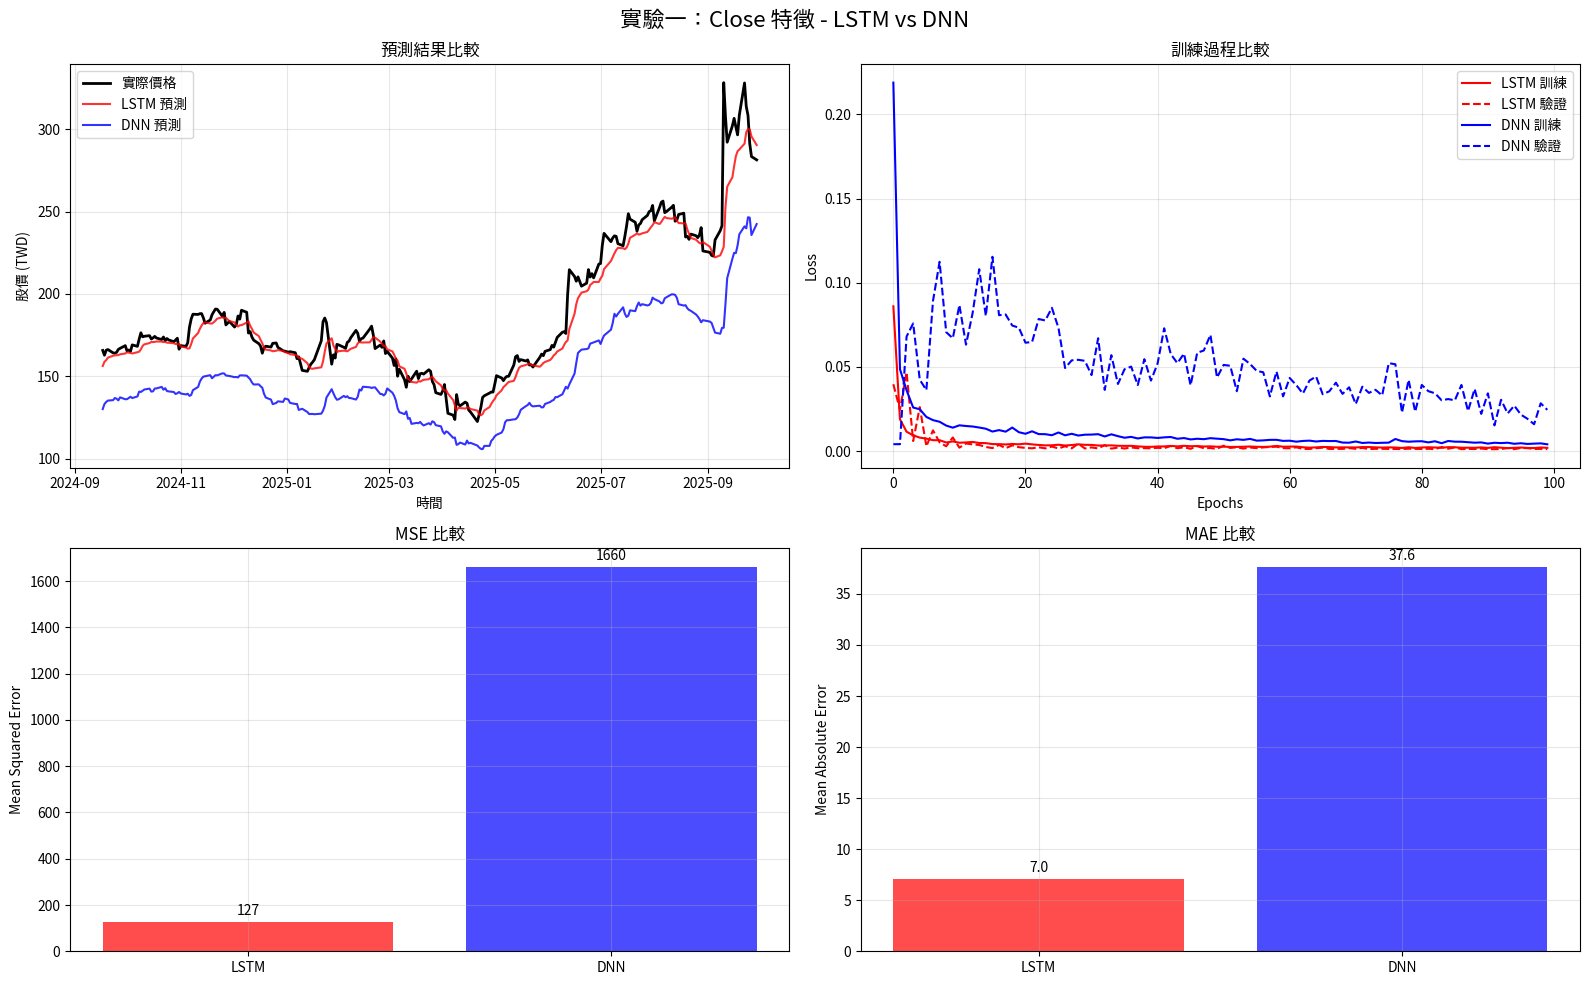

 實驗一完成！


In [17]:
# 執行實驗一
print(" 開始執行實驗一...")
close_exp_results, close_data, close_features = run_close_experiment()
print(" 實驗一完成！")

In [18]:
def run_ohlcv_experiment():

    print(" 實驗二設計：")
    print("   特徵：完整 OHLCV (Open, High, Low, Close, Volume)")
    print("   模型：LSTM vs DNN")
    print("   目標：比較多元特徵下的模型架構效果")

    # 準備 OHLCV 特徵
    ohlcv_data, ohlcv_features = prepare_ohlcv_features(stock_data)

    print(f"\n OHLCV 特徵資料:")
    print(f"   資料形狀: {ohlcv_data.shape}")
    print(f"   特徵數量: {len(ohlcv_features)}")
    print(f"   特徵列表: {ohlcv_features}")

    # 準備訓練資料
    X_train, y_train, X_test, y_test, scaler, train_data, test_data, target_idx = prepare_data(
        ohlcv_data, WINDOW_SIZE, 'Close')

    print(f"\n 資料集概覽:")
    print(f"   訓練集: X{X_train.shape}, y{y_train.shape}")
    print(f"   測試集: X{X_test.shape}, y{y_test.shape}")
    print(f"   特徵維度提升: 1 → {len(ohlcv_features)} (5倍)")

    # 初始化結果字典
    ohlcv_results = {}

    # ========================================================================
    # LSTM 模型實驗
    # ========================================================================
    print(f"\n{' LSTM 模型訓練 (多特徵)':^50}")
    print("-" * 50)

    # 建立 LSTM 模型（多元輸入）
    lstm_model = build_lstm_model((WINDOW_SIZE, len(ohlcv_features)), 1)
    print(f" LSTM 輸入維度: ({WINDOW_SIZE}, {len(ohlcv_features)})")
    lstm_model.summary()

    # 訓練評估
    lstm_history, lstm_train_loss, lstm_test_loss, lstm_pred = train_and_evaluate(
        lstm_model, X_train, y_train, X_test, y_test)

    # 反正規化預測結果
    y_true_actual, lstm_pred_actual = inverse_transform_predictions(
        scaler, y_test, lstm_pred, len(ohlcv_features), target_idx)

    # 計算評估指標
    lstm_mse = mean_squared_error(y_true_actual, lstm_pred_actual)
    lstm_mae = mean_absolute_error(y_true_actual, lstm_pred_actual)

    print(f" LSTM (多元特徵) 結果:")
    print(f"   MSE: {lstm_mse:.0f}")
    print(f"   MAE: {lstm_mae:.2f}")
    print(f"   RMSE: {np.sqrt(lstm_mse):.2f}")

    # 儲存結果
    ohlcv_results['lstm'] = {
        'model': lstm_model,
        'history': lstm_history,
        'y_true': y_true_actual,
        'y_pred': lstm_pred_actual,
        'mse': lstm_mse,
        'mae': lstm_mae,
        'train_loss': lstm_train_loss,
        'test_loss': lstm_test_loss
    }

    # ========================================================================
    # DNN 模型實驗
    # ========================================================================
    print(f"\n{' DNN 模型訓練 (多元特徵)':^50}")
    print("-" * 50)

    # 準備 DNN 輸入（攤平）
    X_train_flat = X_train.reshape(X_train.shape[0], -1)
    X_test_flat = X_test.reshape(X_test.shape[0], -1)

    print(f" DNN 多元特徵輸入攤平:")
    print(f"   原始: {X_train.shape} → 攤平: {X_train_flat.shape}")
    print(f"   總特徵數: {X_train_flat.shape[1]} (20天 × 5特徵)")

    # 建立 DNN 模型（更大容量處理多元特徵）
    dnn_model = build_dnn_model((X_train_flat.shape[1],), 1,
                               hidden_units=[256, 128, 64])  # 增加容量
    dnn_model.summary()

    # 訓練評估
    dnn_history, dnn_train_loss, dnn_test_loss, dnn_pred = train_and_evaluate(
        dnn_model, X_train_flat, y_train, X_test_flat, y_test)

    # 反正規化預測結果
    _, dnn_pred_actual = inverse_transform_predictions(
        scaler, y_test, dnn_pred, len(ohlcv_features), target_idx)

    # 計算評估指標
    dnn_mse = mean_squared_error(y_true_actual, dnn_pred_actual)
    dnn_mae = mean_absolute_error(y_true_actual, dnn_pred_actual)

    print(f" DNN (多元特徵) 結果:")
    print(f"   MSE: {dnn_mse:.0f}")
    print(f"   MAE: {dnn_mae:.2f}")
    print(f"   RMSE: {np.sqrt(dnn_mse):.2f}")

    # 儲存結果
    ohlcv_results['dnn'] = {
        'model': dnn_model,
        'history': dnn_history,
        'y_true': y_true_actual,
        'y_pred': dnn_pred_actual,
        'mse': dnn_mse,
        'mae': dnn_mae,
        'train_loss': dnn_train_loss,
        'test_loss': dnn_test_loss
    }

    # ========================================================================
    # 實驗二結果比較
    # ========================================================================
    print(f"\n{' 實驗二結果比較':^50}")
    print("="*50)

    # 比較分析
    improvement = (dnn_mse - lstm_mse) / dnn_mse * 100

    print(f"\n 多元特徵模型效果比較:")
    print(f"   LSTM MSE: {lstm_mse:.0f}")
    print(f"   DNN MSE:  {dnn_mse:.0f}")

    if improvement > 0:
        print(f"   ✅ LSTM 比 DNN 優秀 {improvement:.1f}%")
        better_model = "LSTM"
    else:
        print(f"   ✅ DNN 比 LSTM 優秀 {abs(improvement):.1f}%")
        better_model = "DNN"

    print(f"\n 實驗二洞察:")
    print(f"   在多元特徵 (OHLCV) 設定下，{better_model} 表現更優")

    if better_model == "LSTM":
        print("   • LSTM 能有效整合多元時序特徵")
        print("   • 時序建模在複雜特徵下仍保持優勢")
        print("   • LSTM 的門控機制能選擇性使用不同特徵")
    else:
        print("   • DNN 在高維特徵空間中表現出色")
        print("   • 多層非線性轉換有效處理特徵交互")
        print("   • 增加的網路容量充分利用了豐富特徵")

    # 視覺化比較
    plot_experiment_results(ohlcv_results, test_data.index[WINDOW_SIZE:],
                           "實驗二：OHLCV 特徵 - LSTM vs DNN",
                           {"LSTM": "green", "DNN": "orange"})

    return ohlcv_results, ohlcv_data, ohlcv_features

 開始執行實驗二...
 實驗二設計：
   特徵：完整 OHLCV (Open, High, Low, Close, Volume)
   模型：LSTM vs DNN
   目標：比較多元特徵下的模型架構效果
 準備 OHLCV 完整特徵...
 OHLCV 特徵準備完成，形狀: (1443, 3)
特徵維度: ['Open', 'High', 'Low']

 OHLCV 特徵資料:
   資料形狀: (1443, 3)
   特徵數量: 3
   特徵列表: ['Open', 'High', 'Low']

 準備 Close 預測資料...
 目標欄位: Low (索引: 2)
 時序分割: 訓練 1154 筆，測試 289 筆
 MinMax 正規化完成 (0-1 縮放)
 建立時序資料集，視窗大小: 30 天
 時序資料集建構完成
   輸入形狀 X: (1124, 30, 3) (樣本數, 時間步長, 特徵數)
   目標形狀 y: (1124,)
 建立時序資料集，視窗大小: 30 天
 時序資料集建構完成
   輸入形狀 X: (259, 30, 3) (樣本數, 時間步長, 特徵數)
   目標形狀 y: (259,)

 資料集概覽:
   訓練集: X(1124, 30, 3), y(1124,)
   測試集: X(259, 30, 3), y(259,)
   特徵維度提升: 1 → 3 (5倍)

                  LSTM 模型訓練 (多特徵)                 
--------------------------------------------------
 建立 LSTM 時序預測模型...
   輸入形狀: (30, 3)
   LSTM 單元數: 64
   全連接層結構: [64, 32]
 LSTM 模型建構完成
 LSTM 輸入維度: (30, 3)


Model: "LSTM_Stock_Predictor"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ LSTM_Layer (LSTM)               │ (None, 64)             │        17,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dense_1 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dense_2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dropout_2 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Output (Dense)                  │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,681 (92.50 KB)

 Trainable params: 23,681 (92.50 KB)

 Non-trainable params: 0 (0.00 B)

 開始訓練 LSTM_Stock_Predictor...
   參數：100 epochs, batch_size=128
Epoch 1/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0698 - mae: 0.2164 - val_loss: 0.0098 - val_mae: 0.0839
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0152 - mae: 0.0968 - val_loss: 0.0136 - val_mae: 0.1045
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0118 - mae: 0.0767 - val_loss: 0.0283 - val_mae: 0.1591
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0084 - mae: 0.0678 - val_loss: 0.0062 - val_mae: 0.0662
Epoch 5/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0083 - mae: 0.0686 - val_loss: 0.0113 - val_mae: 0.0962
Epoch 6/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0069 - mae: 0.0626 - val_loss: 0.0070 - val_mae: 0.0724
Epoch 7/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0070 - mae: 0.0602 - val_loss: 0.0109 - val_mae: 0.0956
Epoch 8/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0058 - mae: 0.0568 - val_loss: 0.0061 - val_mae: 0.0681
Epoch 9/10

Model: "DNN_Stock_Predictor"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Dense_1 (Dense)                 │ (None, 256)            │        23,296 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dense_2 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dense_3 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Output (Dense)                  │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 64,513 (252.00 KB)

 Trainable params: 64,513 (252.00 KB)

 Non-trainable params: 0 (0.00 B)

 開始訓練 DNN_Stock_Predictor...
   參數：100 epochs, batch_size=128
Epoch 1/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0601 - mae: 0.1741 - val_loss: 0.0534 - val_mae: 0.2175
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0220 - mae: 0.1086 - val_loss: 0.0369 - val_mae: 0.1791
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0204 - mae: 0.1032 - val_loss: 0.0718 - val_mae: 0.2589
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0162 - mae: 0.0940 - val_loss: 0.0404 - val_mae: 0.1891
Epoch 5/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0149 - mae: 0.0895 - val_loss: 0.0829 - val_mae: 0.2784
Epoch 6/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0135 - mae: 0.0837 - val_loss: 0.0567 - val_mae: 0.2278
Epoch 7/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0117 - mae: 0.0796 - val_loss: 0.0907 - val_mae: 0.2927
Epoch 8/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0118 - mae: 0.0797 - val_loss: 0.0579 - val_mae: 0.2316
Epoch 9/100
8/8 ━

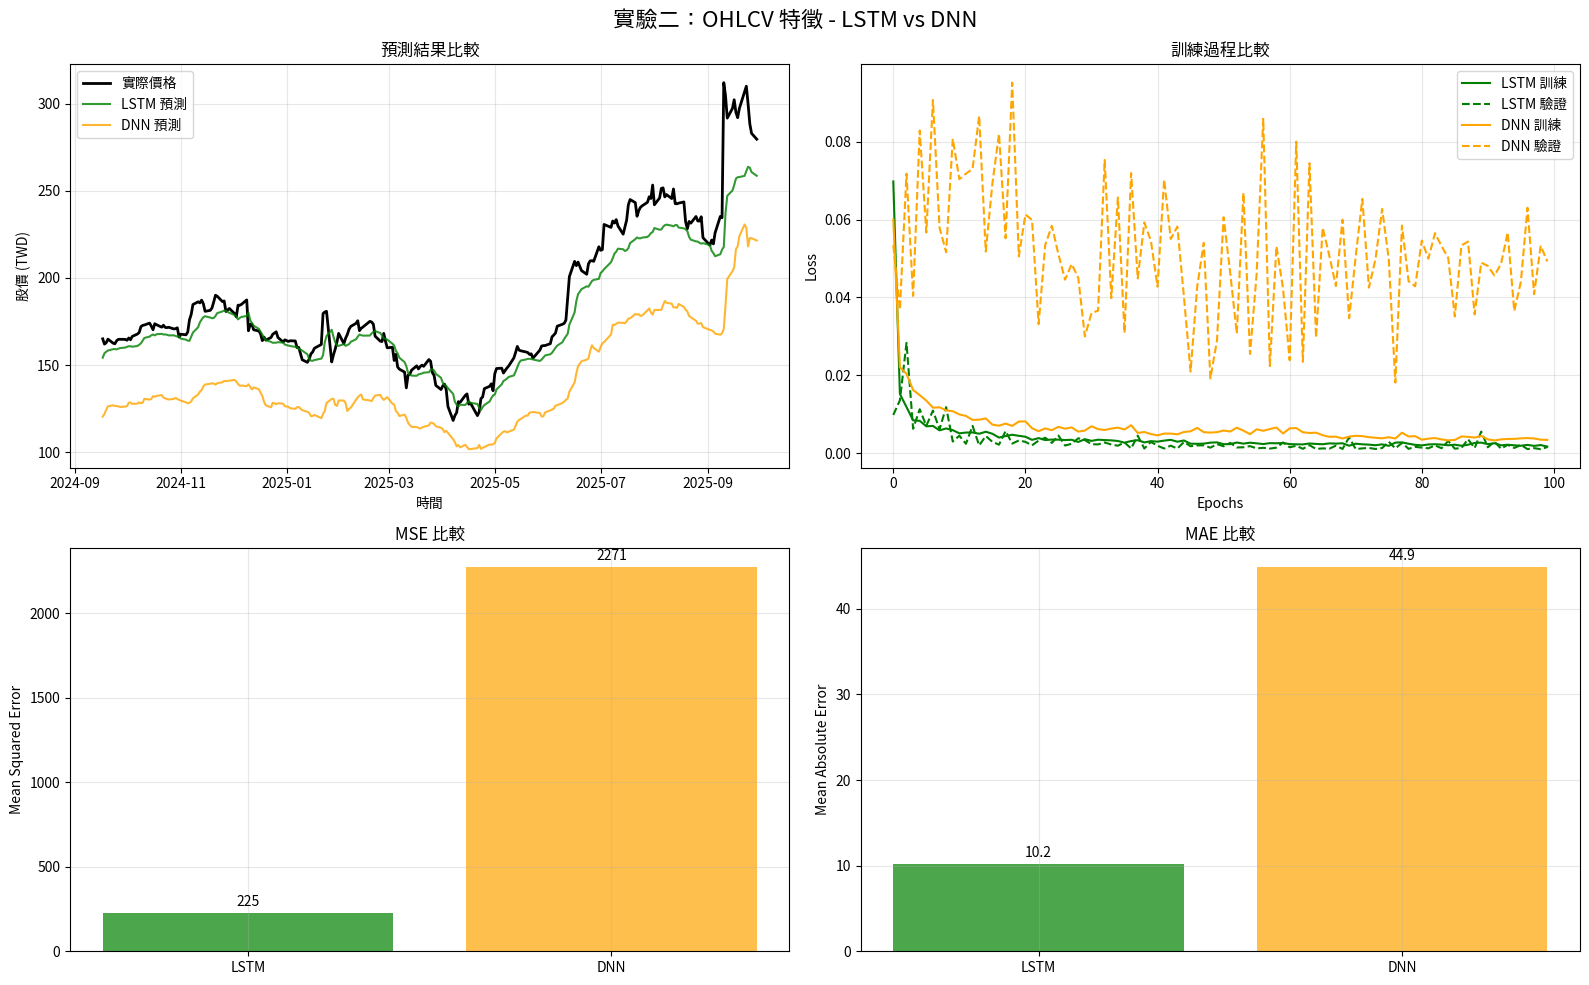

 實驗二完成！


In [19]:
# 執行實驗二
print(" 開始執行實驗二...")
ohlcv_exp_results, ohlcv_data, ohlcv_features = run_ohlcv_experiment()
print(" 實驗二完成！")

In [20]:
#實驗三：綜合比較分析
def run_comprehensive_analysis(close_results, ohlcv_results):

    print(" 實驗三設計：")
    print("   比較維度：特徵工程 × 模型架構")
    print("   組合方案：2×2 = 4種組合")
    # ========================================================================
    # 四種組合結果整理
    # ========================================================================
    print(f"\n{' 四種組合結果總覽':^60}")
    print("="*60)

    all_combinations = {
        'LSTM + Close': {
            'mse': close_results['lstm']['mse'],
            'mae': close_results['lstm']['mae'],
            'model': 'LSTM',
            'feature': 'Close Only',
            'complexity': 'Low'
        },
        'DNN + Close': {
            'mse': close_results['dnn']['mse'],
            'mae': close_results['dnn']['mae'],
            'model': 'DNN',
            'feature': 'Close Only',
            'complexity': 'Low'
        },
        'LSTM + OHLCV': {
            'mse': ohlcv_results['lstm']['mse'],
            'mae': ohlcv_results['lstm']['mae'],
            'model': 'LSTM',
            'feature': 'OHLCV',
            'complexity': 'High'
        },
        'DNN + OHLCV': {
            'mse': ohlcv_results['dnn']['mse'],
            'mae': ohlcv_results['dnn']['mae'],
            'model': 'DNN',
            'feature': 'OHLCV',
            'complexity': 'High'
        }
    }

    # 排序結果（按 MSE）
    sorted_combinations = sorted(all_combinations.items(), key=lambda x: x[1]['mse'])

    print("\n 模型效果排行榜：")
    for i, (name, metrics) in enumerate(sorted_combinations, 1):
        print(f"   {i}. {name:<15} MSE: {metrics['mse']:.0f}, MAE: {metrics['mae']:.2f}")

    best_combo = sorted_combinations[0]
    worst_combo = sorted_combinations[-1]

    print(f"\n 最佳組合: {best_combo[0]}")
    print(f"   MSE: {best_combo[1]['mse']:.0f}")
    print(f"   改善幅度: 比最差組合優秀 {((worst_combo[1]['mse'] - best_combo[1]['mse']) / worst_combo[1]['mse'] * 100):.1f}%")

    # ========================================================================
    # 特徵工程效果分析
    # ========================================================================
    print(f"\n{' 特徵工程效果分析':^60}")
    print("="*60)

    # LSTM 模型的特徵效果
    lstm_close_mse = close_results['lstm']['mse']
    lstm_ohlcv_mse = ohlcv_results['lstm']['mse']
    lstm_feature_improvement = (lstm_close_mse - lstm_ohlcv_mse) / lstm_close_mse * 100

    print(f"\n LSTM 模型特徵比較:")
    print(f"   Close Only MSE: {lstm_close_mse:.0f}")
    print(f"   OHLCV MSE:      {lstm_ohlcv_mse:.0f}")
    if lstm_feature_improvement > 0:
        print(f"    OHLCV 比 Close Only 改善 {lstm_feature_improvement:.1f}%")
    else:
        print(f"    OHLCV 比 Close Only 退步 {abs(lstm_feature_improvement):.1f}%")

    # DNN 模型的特徵效果
    dnn_close_mse = close_results['dnn']['mse']
    dnn_ohlcv_mse = ohlcv_results['dnn']['mse']
    dnn_feature_improvement = (dnn_close_mse - dnn_ohlcv_mse) / dnn_close_mse * 100

    print(f"\n DNN 模型特徵比較:")
    print(f"   Close Only MSE: {dnn_close_mse:.0f}")
    print(f"   OHLCV MSE:      {dnn_ohlcv_mse:.0f}")
    if dnn_feature_improvement > 0:
        print(f"    OHLCV 比 Close Only 改善 {dnn_feature_improvement:.1f}%")
    else:
        print(f"    OHLCV 比 Close Only 退步 {abs(dnn_feature_improvement):.1f}%")

    # ========================================================================
    # 模型架構效果分析
    # ========================================================================
    print(f"\n{' 模型架構效果分析':^60}")
    print("="*60)

    # Close Only 特徵下的模型比較
    close_model_improvement = (dnn_close_mse - lstm_close_mse) / dnn_close_mse * 100

    print(f"\n Close Only 特徵模型比較:")
    print(f"   LSTM MSE: {lstm_close_mse:.0f}")
    print(f"   DNN MSE:  {dnn_close_mse:.0f}")
    if close_model_improvement > 0:
        print(f"    LSTM 比 DNN 優秀 {close_model_improvement:.1f}%")
    else:
        print(f"    DNN 比 LSTM 優秀 {abs(close_model_improvement):.1f}%")

    # OHLCV 特徵下的模型比較
    ohlcv_model_improvement = (dnn_ohlcv_mse - lstm_ohlcv_mse) / dnn_ohlcv_mse * 100

    print(f"\n OHLCV 特徵模型比較:")
    print(f"   LSTM MSE: {lstm_ohlcv_mse:.0f}")
    print(f"   DNN MSE:  {dnn_ohlcv_mse:.0f}")
    if ohlcv_model_improvement > 0:
        print(f"    LSTM 比 DNN 優秀 {ohlcv_model_improvement:.1f}%")
    else:
        print(f"    DNN 比 LSTM 優秀 {abs(ohlcv_model_improvement):.1f}%")

    # ========================================================================
    # 交互作用分析
    # ========================================================================
    print(f"\n{' 特徵×模型交互作用分析':^60}")
    print("="*60)

    # 分析特徵工程對不同模型的影響差異
    lstm_feature_effect = lstm_ohlcv_mse - lstm_close_mse
    dnn_feature_effect = dnn_ohlcv_mse - dnn_close_mse

    print(f"\n 特徵工程效果差異:")
    print(f"   LSTM 特徵效果: {lstm_feature_effect:+.0f} MSE")
    print(f"   DNN 特徵效果:  {dnn_feature_effect:+.0f} MSE")

    if abs(lstm_feature_effect - dnn_feature_effect) > 100:  # 顯著差異閾值
        if lstm_feature_effect < dnn_feature_effect:
            print("    LSTM 對多元特徵的適應性更好")
        else:
            print("    DNN 對多元特徵的適應性更好")
    else:
        print("    兩種模型對特徵工程的響應相似")

    return all_combinations, sorted_combinations

def plot_comprehensive_comparison(close_results, ohlcv_results):

    # 創建 2×3 的子圖布局，但只使用5個位置
    fig = plt.figure(figsize=(20, 12))
    fig.suptitle('實驗三：綜合比較分析', fontsize=16, fontweight='bold')

    # 獲取測試日期（使用較短的資料集）
    min_length = min(
        len(close_results['lstm']['y_true']),
        len(ohlcv_results['lstm']['y_true'])
    )

    # 獲取對應的測試日期
    # 假設我們有股票資料的索引，這裡創建測試日期序列
    # 在實際使用中，這應該從 test_data.index[WINDOW_SIZE:] 獲取
    test_dates = pd.date_range(start='2023-01-01', periods=min_length, freq='D')

    # 1. 特徵比較 - LSTM 模型
    ax1 = plt.subplot(2, 3, 1)
    ax1.plot(test_dates, close_results['lstm']['y_true'][:min_length],
             label='實際價格', color='black', linewidth=2)
    ax1.plot(test_dates, close_results['lstm']['y_pred'][:min_length],
             label='LSTM (Close)', color='red', alpha=0.8)
    ax1.plot(test_dates, ohlcv_results['lstm']['y_pred'][:min_length],
             label='LSTM (OHLCV)', color='blue', alpha=0.8)
    ax1.set_title('特徵工程比較：LSTM 模型', fontweight='bold')
    ax1.set_xlabel('日期')
    ax1.set_ylabel('股價 (TWD)')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    # 設定日期格式
    ax1.tick_params(axis='x', rotation=45)

    # 2. 特徵比較 - DNN 模型
    ax2 = plt.subplot(2, 3, 2)
    ax2.plot(test_dates, close_results['dnn']['y_true'][:min_length],
             label='實際價格', color='black', linewidth=2)
    ax2.plot(test_dates, close_results['dnn']['y_pred'][:min_length],
             label='DNN (Close)', color='red', alpha=0.8)
    ax2.plot(test_dates, ohlcv_results['dnn']['y_pred'][:min_length],
             label='DNN (OHLCV)', color='blue', alpha=0.8)
    ax2.set_title('特徵工程比較：DNN 模型', fontweight='bold')
    ax2.set_xlabel('日期')
    ax2.set_ylabel('股價 (TWD)')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    # 設定日期格式
    ax2.tick_params(axis='x', rotation=45)

    # 3. 模型架構比較 - Close 特徵
    ax3 = plt.subplot(2, 3, 3)
    ax3.plot(test_dates, close_results['lstm']['y_true'][:min_length],
             label='實際價格', color='black', linewidth=2)
    ax3.plot(test_dates, close_results['lstm']['y_pred'][:min_length],
             label='LSTM', color='green', alpha=0.8)
    ax3.plot(test_dates, close_results['dnn']['y_pred'][:min_length],
             label='DNN', color='orange', alpha=0.8)
    ax3.set_title('模型架構比較：Close 特徵', fontweight='bold')
    ax3.set_xlabel('日期')
    ax3.set_ylabel('股價 (TWD)')
    ax3.legend()
    ax3.grid(True, alpha=0.3)
    # 設定日期格式
    ax3.tick_params(axis='x', rotation=45)

    # 4. 模型架構比較 - OHLCV 特徵
    ax4 = plt.subplot(2, 3, 4)
    ax4.plot(test_dates, ohlcv_results['lstm']['y_true'][:min_length],
             label='實際價格', color='black', linewidth=2)
    ax4.plot(test_dates, ohlcv_results['lstm']['y_pred'][:min_length],
             label='LSTM', color='green', alpha=0.8)
    ax4.plot(test_dates, ohlcv_results['dnn']['y_pred'][:min_length],
             label='DNN', color='orange', alpha=0.8)
    ax4.set_title('模型架構比較：OHLCV 特徵', fontweight='bold')
    ax4.set_xlabel('日期')
    ax4.set_ylabel('股價 (TWD)')
    ax4.legend()
    ax4.grid(True, alpha=0.3)
    # 設定日期格式
    ax4.tick_params(axis='x', rotation=45)

    # 5. MSE 綜合比較 (佔據右下角兩個位置)
    ax5 = plt.subplot(2, 3, (5, 6))  # 跨兩個子圖位置

    # 準備資料
    combinations = ['LSTM\n+ Close', 'DNN\n+ Close', 'LSTM\n+ OHLCV', 'DNN\n+ OHLCV']
    mse_values = [
        close_results['lstm']['mse'],
        close_results['dnn']['mse'],
        ohlcv_results['lstm']['mse'],
        ohlcv_results['dnn']['mse']
    ]

    # 根據效果排序決定顏色（效果越好顏色越深）
    sorted_indices = np.argsort(mse_values)
    colors = ['#2E8B57', '#4682B4', '#DAA520', '#CD853F']  # 從深綠到淺棕

    # 繪製柱狀圖
    bars = ax5.bar(combinations, mse_values, color=colors, alpha=0.8, edgecolor='black', linewidth=1)

    ax5.set_title('四種組合 MSE 效果總覽', fontsize=14, fontweight='bold')
    ax5.set_ylabel('Mean Squared Error (MSE)', fontsize=12)
    ax5.set_xlabel('模型組合', fontsize=12)

    # 在柱狀圖上標註數值
    for bar, value in zip(bars, mse_values):
        height = bar.get_height()
        ax5.text(bar.get_x() + bar.get_width()/2, height + max(mse_values)*0.02,
                f'{value:.0f}', ha='center', va='bottom', fontweight='bold', fontsize=11)

    # 標示最佳結果
    best_idx = np.argmin(mse_values)
    bars[best_idx].set_edgecolor('red')
    bars[best_idx].set_linewidth(3)

    # 添加最佳標記
    ax5.annotate('最佳',
                xy=(best_idx, mse_values[best_idx]),
                xytext=(best_idx, mse_values[best_idx] + max(mse_values)*0.15),
                ha='center', va='bottom', fontsize=12, fontweight='bold', color='red',
                arrowprops=dict(arrowstyle='->', color='red', lw=2))

    # 添加改善百分比標註
    worst_mse = max(mse_values)
    best_mse = min(mse_values)
    improvement = ((worst_mse - best_mse) / worst_mse) * 100

    ax5.text(0.98, 0.95, f'最大改善幅度: {improvement:.1f}%',
             transform=ax5.transAxes, ha='right', va='top',
             bbox=dict(boxstyle='round,pad=0.3', facecolor='lightblue', alpha=0.7),
             fontsize=10, fontweight='bold')

    ax5.grid(True, alpha=0.3, axis='y')
    ax5.set_ylim(0, max(mse_values) * 1.3)

    # 調整子圖間距
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # 為總標題留出空間
    plt.show()


 開始執行綜合分析...
 實驗三設計：
   比較維度：特徵工程 × 模型架構
   組合方案：2×2 = 4種組合

                          四種組合結果總覽                          

 模型效果排行榜：
   1. LSTM + Close    MSE: 127, MAE: 7.05
   2. LSTM + OHLCV    MSE: 225, MAE: 10.18
   3. DNN + Close     MSE: 1660, MAE: 37.60
   4. DNN + OHLCV     MSE: 2271, MAE: 44.85

 最佳組合: LSTM + Close
   MSE: 127
   改善幅度: 比最差組合優秀 94.4%

                          特徵工程效果分析                          

 LSTM 模型特徵比較:
   Close Only MSE: 127
   OHLCV MSE:      225
    OHLCV 比 Close Only 退步 76.2%

 DNN 模型特徵比較:
   Close Only MSE: 1660
   OHLCV MSE:      2271
    OHLCV 比 Close Only 退步 36.9%

                          模型架構效果分析                          

 Close Only 特徵模型比較:
   LSTM MSE: 127
   DNN MSE:  1660
    LSTM 比 DNN 優秀 92.3%

 OHLCV 特徵模型比較:
   LSTM MSE: 225
   DNN MSE:  2271
    LSTM 比 DNN 優秀 90.1%

                         特徵×模型交互作用分析                        

 特徵工程效果差異:
   LSTM 特徵效果: +97 MSE
   DNN 特徵效果:  +612 MSE
    LSTM 對多元特徵的適應性更好


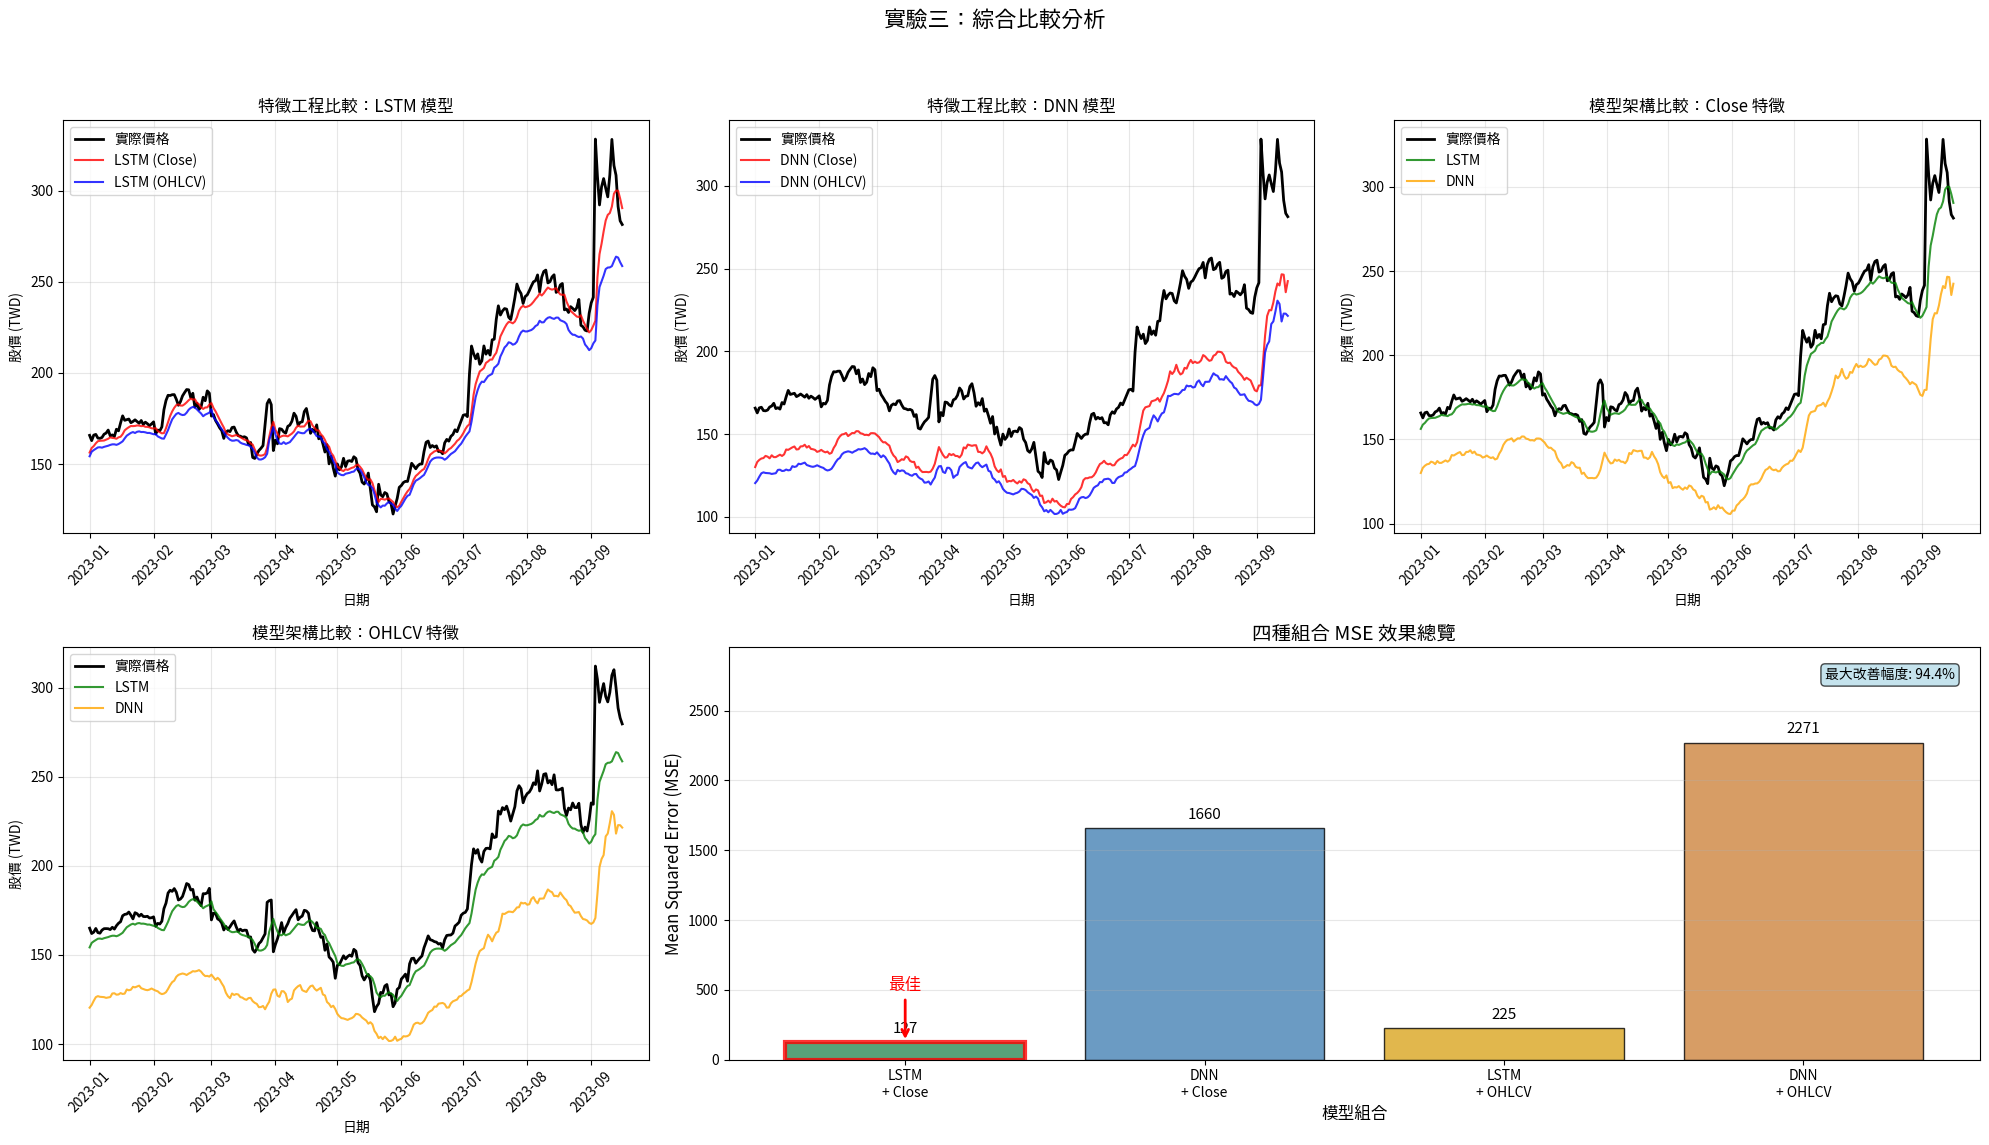

In [21]:
# 執行綜合分析
print(" 開始執行綜合分析...")
all_combos, sorted_combos = run_comprehensive_analysis(close_exp_results, ohlcv_exp_results)

# 視覺化綜合比較
plot_comprehensive_comparison(close_exp_results, ohlcv_exp_results)
